# Reduce

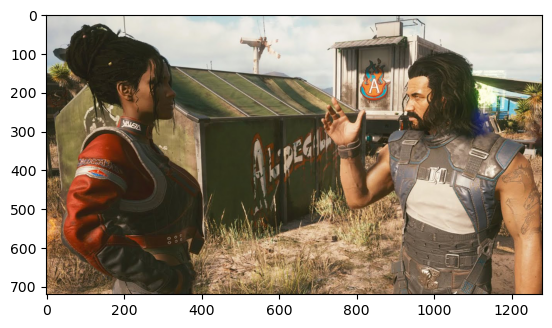

uint8
(720, 1280, 3)
Original: min = 0, max = 255


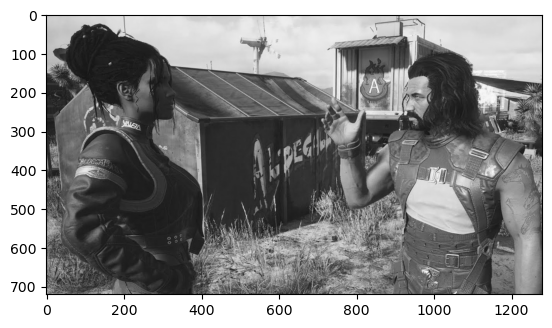

c:\Users\user\.conda\envs\bay_gpu\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\user\.conda\envs\bay_gpu\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Final max value: 205
Final min value: 0


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(uint8, 1d, C))
 
There are 4 candidate implementations:
[1m    - Of which 4 did not match due to:
    Overload of function 'int': File: <numerous>: Line N/A.
      With argument(s): '(array(uint8, 1d, C))':[0m
[1m     No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<class 'int'>)[0m
[0m[1mDuring: typing of call at C:\Users\user\AppData\Local\Temp\ipykernel_5152\4223068739.py (37)
[0m
[1m
File "C:\Users\user\AppData\Local\Temp\ipykernel_5152\4223068739.py", line 37:[0m
[1mdef changing(src, dst, min_val,max_val):
    <source elided>
    if tidx < src.shape[0]: 
[1m        g = int(src[tidx, 0])
[0m        [1m^[0m[0m


In [10]:
import numba
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time

hostInp=plt.imread("../images/maxresdefault.jpg")
plt.imshow(hostInp)
plt.show()
print(hostInp.dtype)
(H,W,C) = hostInp.shape
print(hostInp.shape)
max_w = np.max(hostInp)
min_w = np.min(hostInp)
print(f"Original: min = {min_w}, max = {max_w}")
pixelcount= H*W
hostInp=hostInp.reshape((pixelcount,3))

devOut = cuda.device_array((pixelcount, C), np.uint8)
devOut2 = cuda.device_array((pixelcount, C), np.uint8)

hostOut=np.zeros((H,W,C),np.uint8)

devInp=cuda.to_device(hostInp)

@cuda.jit
def grayscale_threshold(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if tidx < src.shape[0]: 
        g = np.uint8((float(src[tidx, 0]) + float(src[tidx, 1]) + float(src[tidx, 2])) / 3)
        dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

@cuda.jit
def changing(src, dst, min_val,max_val):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if tidx < src.shape[0]: 
        g = int(src[tidx, 0])
        min_g = int(min_val[0])
        max_g = int(max_val[0])
        gg = (g - min_g) * 255 // (max_g - min_g) 
        dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = np.uint8(gg)


@cuda.jit
def find_max(d_input, d_maximum):
    gtid = cuda.grid(1)
    ltid = cuda.threadIdx.x
    bdim = cuda.blockDim.x

    shared = cuda.shared.array(shape=64 , dtype=d_input.dtype)
    if gtid < len(d_input):
        shared[ltid] = d_input[gtid]
    cuda.syncthreads()


    stride = bdim // 2
    while stride > 0:
        if ltid < stride and shared[ltid] < shared[ltid + stride]:
            shared[ltid] = shared[ltid + stride]
        cuda.syncthreads()
        stride //= 2
    if ltid == 0:
        d_maximum[cuda.blockIdx.x] = shared[0]


@cuda.jit
def find_min(d_input, d_maximum):
    gtid = cuda.grid(1)
    ltid = cuda.threadIdx.x
    bdim = cuda.blockDim.x

    shared = cuda.shared.array(shape=64 , dtype=numba.int32)
    if gtid < len(d_input):
        shared[ltid] = d_input[gtid]
    cuda.syncthreads()


    stride = bdim // 2
    while stride > 0:
        if ltid < stride and shared[ltid] > shared[ltid + stride]:
            shared[ltid] = shared[ltid + stride]
        cuda.syncthreads()
        stride //= 2
    if ltid == 0:
        d_maximum[cuda.blockIdx.x] = shared[0]




blockSize = 64
gridSize = (pixelcount + blockSize - 1) // blockSize
t1 = time.time()
grayscale_threshold[gridSize, blockSize](devInp, devOut)
cuda.synchronize()
hostOut = devOut.copy_to_host().reshape(H, W, C)
plt.imshow(hostOut)
plt.show()


min_val = cuda.device_array(shape=(gridSize,), dtype=np.int32)
max_val = cuda.device_array(shape=(gridSize,), dtype=np.int32)
tempmax = devOut[0]
tempmin = devOut[0]


while gridSize > 1:
    find_max[gridSize, blockSize](tempmax, max_val)
    find_min[gridSize, blockSize](tempmin, min_val)
    cuda.synchronize()

    tempmax = max_val
    tempmin = min_val
    gridSize = (gridSize + blockSize - 1) // blockSize

# Copy final result to host
final_max = max_val.copy_to_host()[0]
final_min = min_val.copy_to_host()[0]

print(f"Final max value: {final_max}")
print(f"Final min value: {final_min}")

blockSize = 64
gridSize = (pixelcount + blockSize - 1) // blockSize
realdevOut=cuda.to_device(hostOut)
changing[gridSize, blockSize](realdevOut, devOut2, min_val,max_val)
cuda.synchronize()
hostOut2 = devOut2.copy_to_host().reshape(H, W, C)

t2 = time.time()
#plt.imshow(hostOut)
plt.imshow(hostOut2)
plt.show()
print(f"Processing time: {t2 - t1:.2f} seconds")
if np.array_equal(hostOut, hostOut2):
    print("The images are the same.")